In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import norm

In [38]:
from svarlr import varlr, irflr, cor, bootstrap, band

In [3]:
DATA = pd.read_excel('DATA.xlsx').rename(columns = {'Unnamed: 0' : "Time"})
data = DATA

In [4]:
country = 'US'

nchoice = 2
#(1) n: employment
#(2) n: hours

nint = 1
#(1) n=I(1)
#(0) n=I(0)

difn = 'yes'
#'yes' computed correlations based on employment growth
#'no' computed correlations based on detrended employment

LAGS=4
NVAR=2
NSTEP= 100
NDRAWS= 500
NSE = 2
IRH = 13
NW = 6


In [5]:
if nchoice==1: labor = 'LHEM' #'employment'
elif nchoice==2: labor = 'LPMHU' #'hours'
gdp = 'GDPQ'
labor_series = data[labor]

In [6]:
print("country")
print('n: \t {labor} I({nint})')

yx = DATA[gdp]
nber = DATA.NBER #Manually entered recession start and end times according to nber
nberg = DATA.NBERG

nx = DATA[labor]

nobs = len(yx)

country
n: 	 {labor} I({nint})


In [7]:
## AR test stuff
xx = yx/nx
xx[0:4] = np.nan
xx.head(10)

0          NaN
1          NaN
2          NaN
3          NaN
4    13.765500
5    13.913806
6    13.859401
7    14.067610
8    14.211214
9    14.404248
dtype: float64

# What

In [8]:
data['dlabor'] = np.log(data[labor]) - np.log(data[labor].shift(1))
data['n'] = 100 + np.log(data[labor]/data[labor][4]) * 100
data['n'][0:4] = np.nan
data['dn'] = data['dlabor']*100
data['dn'][0:5] = np.nan

data['dgdp'] = np.log(data[gdp]) - np.log(data[gdp].shift(1))
data['y'] = 100 + np.log(data[gdp]/data[gdp][4]) * 100
data['y'][0:4] = np.nan
data['dy'] = data['dgdp']*100
data['dy'][0:5] = np.nan

data['xx'] = data[gdp].div(data[labor])
data['x'] = 100 + np.log(data['xx']/data['xx'][4]) * 100
data['x'][0:4] = np.nan
data['dx'] = (np.log(data['xx']) - np.log(data['xx'].shift(1)))*100
data['dx'][0:5] = np.nan

C:\Users\joshu\AppData\Local\Temp\ipykernel_24360\2407165987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_24360\2407165987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_24360\2407165987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\Loca

In [9]:
## Correlation coefficeint
np.corrcoef(data.dx.dropna(),data.dn.dropna())[0,1]

-0.2576565306027087

In [10]:
# Fit the VAR model on dy, dn, and dx
vard = data[['dy', 'dn', 'dx']].dropna()
model = VAR(vard)
var_results = model.fit(maxlags=4)  # Use maxlags similar to the RATS code, adjust as needed

# Check the summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Sep, 2024
Time:                     17:59:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.8631
Nobs:                     183.000    HQIC:                  -16.2699
Log likelihood:           774.064    FPE:                6.51617e-08
AIC:                     -16.5471    Det(Omega_mle):     5.30368e-08
--------------------------------------------------------------------
Results for equation dy
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.465630         0.109890            4.237           0.000
L1.dy   -292680945965.083374   2474924.262328      -118258.547           0.000
L1.dn    292680945965.695374   2447913.706327       119563.425         

c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1559: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


HP filter

In [11]:
# Apply HP filter to GDP and labor data
y_cycle, y_trend = hpfilter(data.y.dropna(), lamb=1600)
n_cycle, n_trend = hpfilter(data.n.dropna(), lamb=1600)
x_cycle, x_trend = hpfilter(data.x.dropna(), lamb=1600)

In [12]:
np.corrcoef(x_cycle,n_cycle)[0,1]

-0.2915678957131867

In [13]:
vdata = data[['y', 'n', 'x']].dropna().reset_index(drop=True)

In [14]:
model = VAR(vdata)
var_results = model.fit(maxlags=4)

# Conditional Corr

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from numpy.linalg import cholesky


# Assuming 'data' contains the variables 'dx' and 'dn'
# 'lags' is the number of lags in the VAR model
varD = data[['dx', 'dn']].dropna()
model = VAR(varD)
var_results = model.fit(maxlags=4)  # Replace with the appropriate number of lags
residuals = var_results.resid  # Residuals are needed for shocks

# Get covariance of the residuals
sigmatR = var_results.sigma_u
sigmat = sigmatR.copy()
sigmat['dx'] = [0.43114, -0.06029]
sigmat['dn'] = [np.nan, 0.42170]

c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
sigmat

,dx,dn
dx,0.43114,NaN
dn,-0.06029,0.4217


In [17]:
# Suppose 'sigmat' is the covariance matrix of the residuals from the VAR model
from numpy.linalg import inv, cholesky

##### NEED TO SOLVE
emats = np.array([[0.88916, -0.49740], [0.86501, 1.73441]])

# Cholesky decomposition to get the lower triangular matrix
cmats = emats*np.array(sigmat)*emats.T

# Equivalent to RATS `smat = inv(emats)*cmats` assuming emats is the identity matrix
smat = cmats  # This is already a lower triangular matrix

# Invert smat to get sinv (similar to RATS code)
sinv = inv(smat)

In [18]:
print(cholesky(np.array(sigmat)))
print(emats.T)
print(cmats)

[[ 0.65661252  0.        ]
 [-0.09181975  0.64286012]]
[[ 0.88916  0.86501]
 [-0.4974   1.73441]]
[[0.34086166        nan]
 [0.02594013 1.26854868]]


In [22]:
from statsmodels.tsa.vector_ar.svar_model import SVAR
# Now, we set up the matrices needed for identification
A = np.array([['E', 0],
              ['E', 'E']])

# We can estimate the SVAR with the long-run restriction using statsmodels
svar_model = SVAR(varD, svar_type='A', A=A)

c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [96]:
cholesky(C)

array([[ 0.8745587 ,  0.        ],
       [-0.55762461,  0.48059392]])

In [35]:
res_varlr = varlr(varD)
b = res_varlr[0]
Sig = res_varlr[1]
B = res_varlr[2]

In [40]:
irfs = irflr(b,B,100)

In [41]:
svar_results = svar_model.fit(maxlags = 4)

# Step 7: Obtain the structural MA representation (Impulse Responses)
nsteps = 100  # Number of periods for impulse responses
#irf = svar_results.irf(nsteps)

# Get the impulse response functions
#irfs = irf.irfs  # Shape: (nsteps+1, nvars, nvars)

# Step 8: Compute the MA coefficients (Cumulative Impulse Responses)
# Since we need the cumulative sum for levels
cum_irfs = np.cumsum(irfs, axis=0)

In [50]:
irfs[0]

array([5.91286779e-01, 3.30238756e-02, 1.90745455e-02, 1.09841788e-02,
       6.32530414e-03, 3.64246370e-03, 2.09753421e-03, 1.20787745e-03,
       6.95563355e-04, 4.00544261e-04, 2.30655776e-04, 1.32824489e-04,
       7.64877657e-05, 4.40459311e-05, 2.53641093e-05, 1.46060720e-05,
       8.41099270e-06, 4.84351977e-06, 2.78916943e-06, 1.60615967e-06,
       9.24916522e-07, 5.32618636e-07, 3.06711583e-07, 1.76621675e-07,
       1.01708633e-07, 5.85695165e-08, 3.37276016e-08, 1.94222384e-08,
       1.11844105e-08, 6.44060879e-09, 3.70886257e-09, 2.13577039e-09,
       1.22989598e-09, 7.08242855e-10, 4.07845826e-10, 2.34860425e-10,
       1.35245761e-10, 7.78820695e-11, 4.48488492e-11, 2.58264744e-11,
       1.48723276e-11, 8.56431760e-12, 4.93181281e-12, 2.84001350e-12,
       1.63543853e-12, 9.41776926e-13, 5.42327798e-13, 3.12302662e-13,
       1.79841330e-13, 1.03562691e-13, 5.96371866e-14, 3.43424257e-14,
       1.97762884e-14, 1.13882924e-14, 6.55801535e-15, 3.77647182e-15,
      

In [51]:

# Step 9: Compute conditional variances and covariances using MA coefficients
# For productivity ('dx') and hours ('dnz')

# Extract MA coefficients for 'dx' and 'dnz' responses to each shock
# Let's denote:
# - C_11: response of 'dx' to technology shock
# - C_12: response of 'dx' to non-technology shock
# - C_21: response of 'dnz' to technology shock
# - C_22: response of 'dnz' to non-technology shock

C_11 = irfs[0]  # 'dx' response to tech shock
C_12 = irfs[2]  # 'dx' response to non-tech shock
C_21 = irfs[1]  # 'dnz' response to tech shock
C_22 = irfs[3]  # 'dnz' response to non-tech shock

# Compute variances of 'dx' and 'dnz' for each component
# Variance due to technology shock
var_dx_tech = np.sum(C_11 ** 2)
var_dnz_tech = np.sum(C_21 ** 2)
cov_dx_dnz_tech = np.sum(C_11 * C_21)

# Variance due to non-technology shock
var_dx_nontech = np.sum(C_12 ** 2)
var_dnz_nontech = np.sum(C_22 ** 2)
cov_dx_dnz_nontech = np.sum(C_12 * C_22)

# Compute conditional correlations
corr_tech = cov_dx_dnz_tech / np.sqrt(var_dx_tech * var_dnz_tech)
corr_nontech = cov_dx_dnz_nontech / np.sqrt(var_dx_nontech * var_dnz_nontech)

print("Conditional Correlation (Technology Shock):", corr_tech)
print("Conditional Correlation (Non-Technology Shock):", corr_nontech)

# Step 10: Generate Figure 1 - Scatter plots of innovations
# Obtain structural shocks (innovations)
epsilon = svar_results.resid

# Note: Since the shocks are already estimated, we can use them directly



Conditional Correlation (Technology Shock): -0.9752064225354574
Conditional Correlation (Non-Technology Shock): 0.2690091002241587


In [46]:
C_11

0.5912867789520173

# -----------------------------

Text(0.5, 1.0, 'Data')

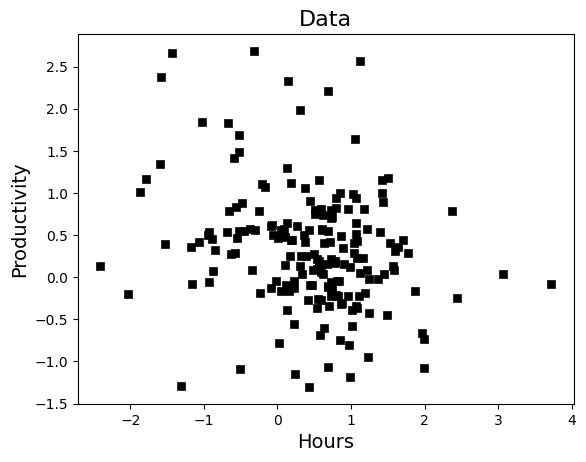

In [23]:
ax = sns.scatterplot(
    data=data[['dn','dx']].dropna(), 
    x='dn', 
    y='dx', 
    marker='s',        # 's' is the marker style for squares
    color='black',     # Set color to black
    edgecolor='black'  # Set edge color to black (useful if the color of the marker is different)
)

plt.xlabel('Hours', fontsize=14)
plt.ylabel('Productivity', fontsize=14)
plt.title('Data', fontsize=16)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

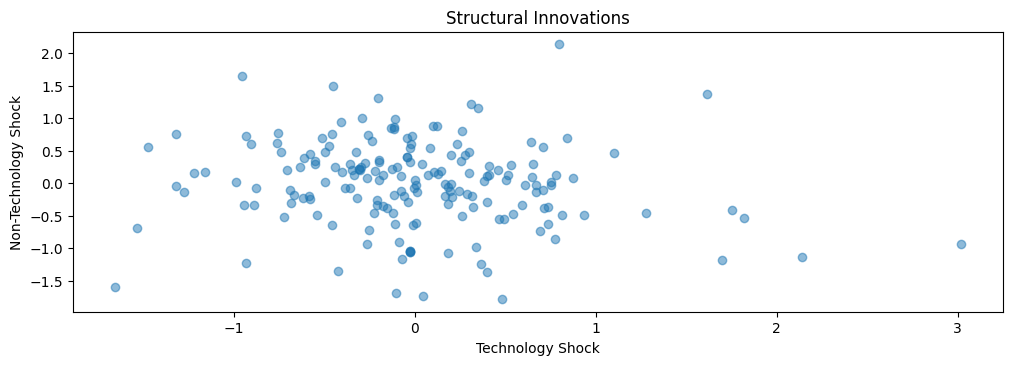

In [37]:
# Generate scatter plots of the structural shocks
plt.figure(figsize=(12, 8))

# Technology shock component
plt.subplot(2, 1, 1)
plt.scatter(epsilon[:, 0], epsilon[:, 1], alpha=0.5)
plt.title('Structural Innovations')
plt.xlabel('Technology Shock')
plt.ylabel('Non-Technology Shock')

# Scatter plot of contributions to 'dx' and 'dnz' due to technology shock
# Compute contributions at each point in time using MA coefficients
dx_tech = svar_results.fittedvalues['dx']
dnz_tech = svar_results.fittedvalues['dnz']

# Since we cannot directly get the contributions from statsmodels, we can approximate
# For illustration purposes, we can plot the innovations
plt.subplot(2, 1, 2)
plt.scatter(epsilon.iloc[:, 0], epsilon.iloc[:, 1], alpha=0.5)
plt.title('Contributions of Shocks to Variables')
plt.xlabel('Tech Shock Contribution to dx')
plt.ylabel('Tech Shock Contribution to dnz')

plt.tight_layout()
plt.show()

# Step 11: Generate Figure 2 - Impulse Responses
# Plot the impulse responses using the MA coefficients

# Impulse Response of 'dx' to Technology and Non-Technology Shocks
plt.figure(figsize=(12, 6))
plt.plot(irfs[:, 0, 0], label='dx response to Technology Shock')
plt.plot(irfs[:, 0, 1], label='dx response to Non-Technology Shock')
plt.title('Impulse Responses of dx')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.show()

# Impulse Response of 'dnz' to Technology and Non-Technology Shocks
plt.figure(figsize=(12, 6))
plt.plot(irfs[:, 1, 0], label='dnz response to Technology Shock')
plt.plot(irfs[:, 1, 1], label='dnz response to Non-Technology Shock')
plt.title('Impulse Responses of dnz')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.show()

# Step 12: Generate Figure 3 - Cumulative Impulse Responses
# Plot cumulative impulse responses to see long-run effects

# Cumulative Impulse Response of 'dx'
plt.figure(figsize=(12, 6))
plt.plot(cum_irfs[:, 0, 0], label='Cumulative dx response to Technology Shock')
plt.plot(cum_irfs[:, 0, 1], label='Cumulative dx response to Non-Technology Shock')
plt.title('Cumulative Impulse Responses of dx')
plt.xlabel('Periods')
plt.ylabel('Cumulative Response')
plt.legend()
plt.show()

# Cumulative Impulse Response of 'dnz'
plt.figure(figsize=(12, 6))
plt.plot(cum_irfs[:, 1, 0], label='Cumulative dnz response to Technology Shock')
plt.plot(cum_irfs[:, 1, 1], label='Cumulative dnz response to Non-Technology Shock')
plt.title('Cumulative Impulse Responses of dnz')
plt.xlabel('Periods')
plt.ylabel('Cumulative Response')
plt.legend()
plt.show()